在過去曾經觀察到不同機構對學生人數多寡影響排名的趨勢不同的現象，因此本專案要將近兩年THE和QS兩個排名機構的公布資料加以比較，判斷該現象是否仍然存在，並找出可能影響排名的因素。

In [347]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from scipy import stats
import matplotlib.pyplot as plt

In [348]:
# read data
qs_2022 = pd.read_csv('../../QS/qs_2022_refine.csv')
qs_2023 = pd.read_csv('../../QS/qs_2023_refine.csv')
the_2022 = pd.read_csv('../../THE/the_2022_refine.csv')
the_2023 = pd.read_csv('../../THE/the_2023_refine.csv')

觀察離群值

In [349]:
mean_xlqs_2022 = qs_2022[qs_2022['Size'] == 'XL']['Total students'].mean()
std_xlqs_2022 = qs_2022[qs_2022['Size'] == 'XL']['Total students'].std()
outlier_schools = qs_2022[qs_2022['Size'] == 'XL'][(qs_2022[qs_2022['Size'] == 'XL']['Total students'] - mean_xlqs_2022) / std_xlqs_2022 > 3].loc[:, 'University'].tolist()
min_outlier_schools = qs_2022[qs_2022['Size'] == 'XL'][(qs_2022[qs_2022['Size'] == 'XL']['Total students'] - mean_xlqs_2022) / std_xlqs_2022 > 3].loc[:, 'Total students'].min()

In [350]:
qs_2022[qs_2022['Size'] == 'XL'][(qs_2022[qs_2022['Size'] == 'XL']['Total students'] - mean_xlqs_2022) / std_xlqs_2022 > 3].loc[:, ['University', 'Total students']]

,University,Total students
105,Universidad Nacional Autonoma de Mexico,151316
560,Cairo University,192930
781,Ain Shams University,155929
966,Al-Azhar University,299054
967,Alexandria University,186865
1149,Damascus University,175080
1159,Mansoura University,179473
1226,Zagazig University,154303


In [351]:
qs_2023[(qs_2023['Total students'] > min_outlier_schools) & [school not in outlier_schools for school in qs_2023['University']]]

,University,Total students,PG rate,UG rate,International students,Int'l PG rate,Int'l UG rate,Total faculty staff,Int'l staff rate,Domestic staff rate,rank
767,Ain Shams University in Cairo,155929,0.86,0.14,9128,0.79,0.21,10912,0.87,0.13,900


In [352]:
the_2022[the_2022['Total Students'] > min_outlier_schools].loc[:, ['University', 'Total Students']]

,University,Total Students
519,Mansoura University,154957
583,Cairo University,231150
799,University of Dhaka,207118
864,National Autonomous University of Mexico,167254
911,University of South Africa,193543
928,Tribhuvan University,428485
948,Ain Shams University,201733
949,Al-Azhar University,376303
950,Alexandria University,188711


In [353]:
the_2023[the_2023['Total Students'] > min_outlier_schools].loc[:, ['University', 'Total Students']]

,University,Total Students
594,University of Dhaka,211424
660,Mansoura University,161977
749,Al-Azhar University,425977
752,Alexandria University,202206
773,Cairo University,224216
916,Tribhuvan University,460632
928,Zagazig University,165556
1043,National Autonomous University of Mexico,172729
1088,University of South Africa,236282


### QS:

- 比較QS學生人數, 師生比, 國際學生人數, Status, Research Output, Size 是否影響 rank

定義變數

In [354]:
X1 = qs_2022['Total students']
X2 = qs_2022['International students']
X3 = qs_2022['Total students'] / qs_2022['Total faculty staff']
X4 = qs_2022['Status'].map({'Private': 0, 'Public': 1})
X5 = qs_2022['Research Output'].map({'Very High': 3, 'High': 2, 'Medium': 1, 'Low': 0})
X6 = qs_2022['Size'].map({'M': 0, 'L': 1, 'S': 2, 'XL': 3})
y = qs_2022['rank']

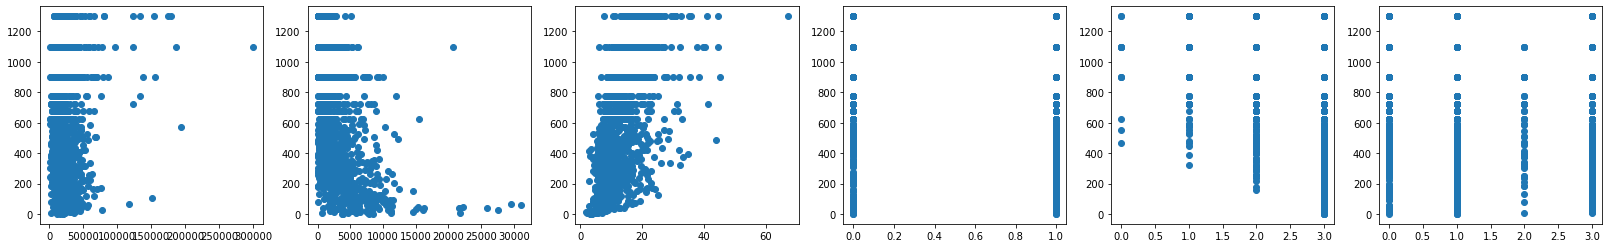

In [355]:
fig = plt.figure(figsize=(28, 4)) 
ax = fig.add_subplot(1, 6, 1)
plt.plot(X1, y, 'o')
ax = fig.add_subplot(1, 6, 2)
plt.plot(X2, y, 'o')
ax = fig.add_subplot(1, 6, 3)
plt.plot(X3, y, 'o')
ax = fig.add_subplot(1, 6, 4)
plt.plot(X4, y, 'o')
ax = fig.add_subplot(1, 6, 5)
plt.plot(X5, y, 'o')
ax = fig.add_subplot(1, 6, 6)
plt.plot(X6, y, 'o')
plt.show()

In [356]:
X = np.c_[X1, X2, X3, X4, X5, X6]
lm = LinearRegression()
reg = lm.fit(X, y)
yhat = reg.predict(X)
R2 = ((y - yhat)** 2).sum() / ((y - y.mean()) ** 2).sum()
print('R square score =', round(1-R2, 2))

se_b = [np.sqrt( ((y - yhat)**2).sum() / (len(y)-2) ) / np.sqrt( ((X[:,i] - X[:,i].mean())**2).sum() ) for i in range(X.shape[1])]

not_sig = []
for i in range(len(reg.coef_)):
    if abs(reg.coef_[i] / se_b[i]) < stats.t.ppf(0.95, df = len(y)-2):
        not_sig = not_sig + [i]
print('第', not_sig, '個變數不顯著')

R square score = 0.56
第 [3] 個變數不顯著


由以上結果可知Status對排名影響不大，可以刪掉

In [357]:
X = np.c_[X1, X2, X3, X5, X6]

reg = lm.fit(X, y)
yhat = reg.predict(X)
R2 = ((y - yhat)** 2).sum() / ((y - y.mean()) ** 2).sum()
print('R square score =', round(1-R2, 2))

se_b = [np.sqrt( ((y - yhat)**2).sum() / (len(y)-2) ) / np.sqrt( ((X[:,i] - X[:,i].mean())**2).sum() ) for i in range(X.shape[1])]

not_sig = []
for i in range(len(reg.coef_)):
    if abs(reg.coef_[i] / se_b[i]) < stats.t.ppf(0.95, df = len(y)-2):
        not_sig = not_sig + [i]
print('第', not_sig, '個變數不顯著')

R square score = 0.55
第 [] 個變數不顯著


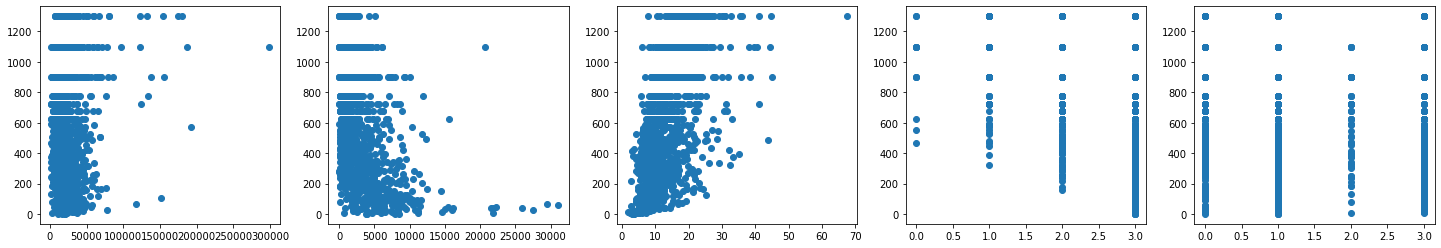

In [358]:
fig = plt.figure(figsize=(25, 4)) 
ax = fig.add_subplot(1, 5, 1)
plt.plot(X1, y, 'o')
ax = fig.add_subplot(1, 5, 2)
plt.plot(X2, y, 'o')
ax = fig.add_subplot(1, 5, 3)
plt.plot(X3, y, 'o')
ax = fig.add_subplot(1, 5, 4)
plt.plot(X5, y, 'o')
ax = fig.add_subplot(1, 5, 5)
plt.plot(X6, y, 'o')
plt.show()

試著調整離群值較多的$x_2, x_3$

In [359]:
X = np.c_[X1, X2**0.5, np.log(X3), X5, X6]
y = qs_2022['rank']
reg = lm.fit(X, y)
yhat = reg.predict(X)
R2 = ((y - yhat)** 2).sum() / ((y - y.mean()) ** 2).sum()
print('R square score =', round(1-R2, 2))

se_b = [np.sqrt( ((y - yhat)**2).sum() / (len(y)-2) ) / np.sqrt( ((X[:,i] - X[:,i].mean())**2).sum() ) for i in range(X.shape[1])]

not_sig = []
for i in range(len(reg.coef_)):
    if abs(reg.coef_[i] / se_b[i]) < stats.t.ppf(0.95, df = len(y)-2):
        not_sig = not_sig + [i]
print('第', not_sig, '個變數不顯著')

R square score = 0.63
第 [] 個變數不顯著


In [360]:
reg.coef_.tolist()

[0.002556628754570428,
 -6.1824398799238525,
 356.0519494692765,
 -146.08902268212915,
 -39.608951427193134]

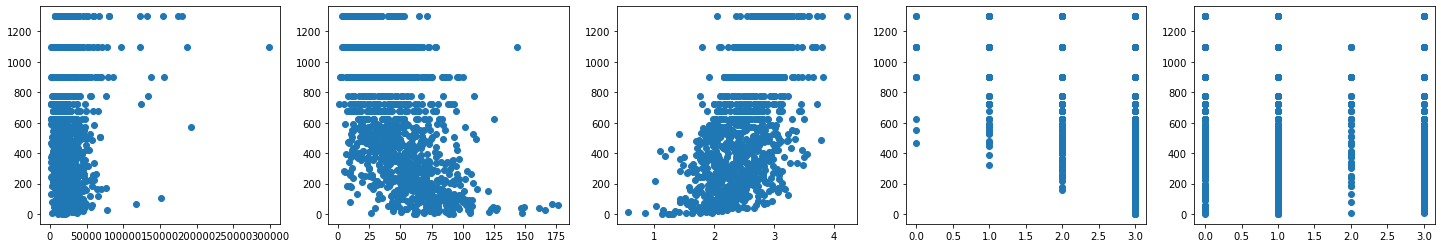

In [361]:
fig = plt.figure(figsize=(25, 4)) 
ax = fig.add_subplot(1, 5, 1)
plt.plot(X1, y, 'o')
ax = fig.add_subplot(1, 5, 2)
plt.plot(X2**0.5, y, 'o')
ax = fig.add_subplot(1, 5, 3)
plt.plot(np.log(X3), y, 'o')
ax = fig.add_subplot(1, 5, 4)
plt.plot(X5, y, 'o')
ax = fig.add_subplot(1, 5, 5)
plt.plot(X6, y, 'o')
plt.show()

最終模型寫為
    $\hat{y} = 0.003 x_1 -6.18 \sqrt{x_2} + 356.05 \log(x_3) - 146.10 x_5 -39.61 x_6$

合併QS當年與前一年的資料

In [362]:
qs = pd.merge(qs_2023[['University', 'Total students', 'International students', 'Total faculty staff', 'Int\'l staff rate', 'Domestic staff rate', 'rank']], 
qs_2022[['University', 'Total students', 'International students', 'Total faculty staff', 'Int\'l staff rate', 'Domestic staff rate', 'Status', 'Research Output', 'Size', 'rank']], 
how = 'inner', on = 'University')

In [363]:
qs = qs.rename(columns={'Total students_x':'Total students_2023',
'International students_x':'International students_2023',
'Total faculty staff_x':'Total faculty staff_2023',
'Int\'l staff rate_x':'Int\'l staff rate_2023',
'Domestic staff rate_x':'Domestic staff rate_2023',
'rank_x':'rank_2023',
'Total students_y':'Total students_2022',
'International students_y':'International students_2022',
'Total faculty staff_y':'Total faculty staff_2022',
'Int\'l staff rate_y':'Int\'l staff rate_2022',
'Domestic staff rate_y':'Domestic staff rate_2022',
'rank_y':'rank_2022'})

- 比較QS學生人數增減, 師生比增減, 國際學生人數增減, Research Output, Size 是否影響 rank增減

In [364]:
students_growth = (qs['Total students_2023']-qs['Total students_2022']) / [max(qs['Total students_2023'][i], qs['Total students_2022'][i]) for i in range(len(qs['Total students_2022']))]
int_stud_growth = qs['International students_2023']/qs['Total students_2023'] - qs['International students_2022']/qs['Total students_2022']
staff_rate_growth = qs['Total students_2023']/qs['Total faculty staff_2023'] - qs['Total students_2022']/qs['Total faculty staff_2022']
rank_growth = qs['rank_2023'] - qs['rank_2022']

qs_compare = pd.concat([qs, students_growth, int_stud_growth, staff_rate_growth, rank_growth], axis = 1)
qs_compare = qs_compare.rename(columns = {0:'students_growth', 1:'int_stud_growth', 2:'staff_rate_growth', 3:'rank_growth'})

In [365]:
qs_less500 = qs_compare[(qs_compare['rank_2022'] <= 500) | (qs_compare['rank_2023'] <= 500)]

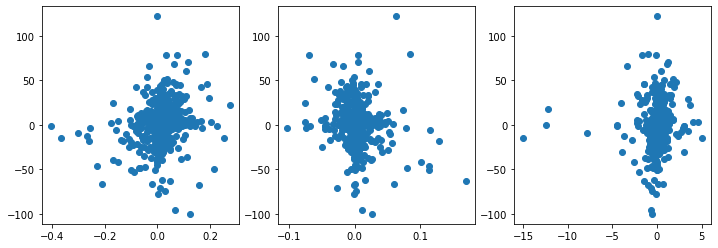

In [366]:
fig = plt.figure(figsize=(12, 4)) 
ax = fig.add_subplot(1, 3, 1)
plt.plot(qs_less500['students_growth'], qs_less500['rank_growth'], 'o')
ax = fig.add_subplot(1, 3, 2)
plt.plot(qs_less500['int_stud_growth'], qs_less500['rank_growth'], 'o')
ax = fig.add_subplot(1, 3, 3)
plt.plot(qs_less500['staff_rate_growth'], qs_less500['rank_growth'], 'o')
plt.show()

由繪圖結果可知，資料的年增和排名增減較無關。

- 比較QS學生人數增減, 師生比增減, 國際學生人數增減, Research Output, Size 是否影響 當年的rank

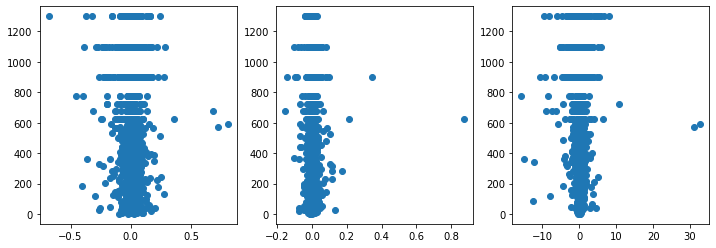

In [367]:
fig = plt.figure(figsize=(12, 4)) 
ax = fig.add_subplot(1, 3, 1)
plt.plot(qs_compare['students_growth'], qs_compare['rank_2023'], 'o')
ax = fig.add_subplot(1, 3, 2)
plt.plot(qs_compare['int_stud_growth'], qs_compare['rank_2023'], 'o')
ax = fig.add_subplot(1, 3, 3)
plt.plot(qs_compare['staff_rate_growth'], qs_compare['rank_2023'], 'o')
plt.show()

由繪圖結果可知，資料的年增和排名也較無關。

### THE:

比較THE學生人數, 師生比, 國際學生人數是否影響 rank

In [368]:
X1 = the_2022['Total Students']
X2 = the_2022['Total Students'] * the_2022['pc of int\'l students']
X3 = the_2022['student staff ratio']
y = the_2022['rank']

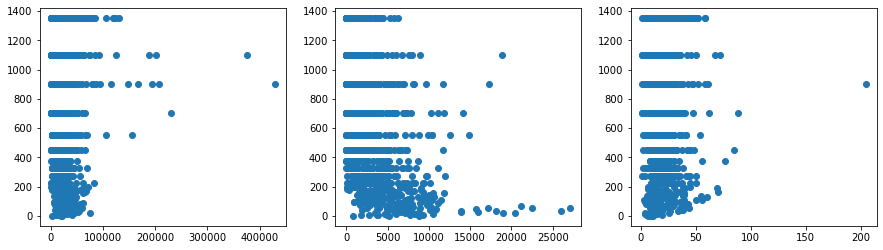

In [369]:
fig = plt.figure(figsize=(15, 4)) 
ax = fig.add_subplot(1, 3, 1)
plt.plot(X1, y, 'o')
ax = fig.add_subplot(1, 3, 2)
plt.plot(X2, y, 'o')
ax = fig.add_subplot(1, 3, 3)
plt.plot(X3, y, 'o')
plt.show()

In [370]:
X = np.c_[X1, X2**0.5, np.log(X3)]

reg = lm.fit(X, y)
yhat = reg.predict(X)
R2 = ((y - yhat)** 2).sum() / ((y - y.mean()) ** 2).sum()
print('R square score =', round(1-R2, 2))

se_b = [np.sqrt( ((y - yhat)**2).sum() / (len(y)-2) ) / np.sqrt( ((X[:,i] - X[:,i].mean())**2).sum() ) for i in range(X.shape[1])]

not_sig = []
for i in range(len(reg.coef_)):
    if abs(reg.coef_[i] / se_b[i]) < stats.t.ppf(0.95, df = len(y)-2):
        not_sig = not_sig + [i]
print('第', not_sig, '個變數不顯著')

R square score = 0.37
第 [] 個變數不顯著


In [371]:
reg.coef_

array([ 2.98849272e-03, -1.04711706e+01,  4.14774763e+01])

由以上結果可知THE的資料本身就比較分散，且排名大於200以上的資料就由區間代替。
因此較無法看出資料和排名的關係，即使做了特徵轉換，關係仍不明顯。

合併THE當年與前一年的資料

In [341]:
the = pd.merge(the_2023[['rank', 'University', 'Total Students', 'student staff ratio', 'pc of int\'l students']],
the_2022[['rank', 'University', 'Total Students', 'student staff ratio', 'pc of int\'l students']],
how = 'inner', on = 'University')

In [342]:
the = the.rename(columns={'rank_x':'rank_2023', 'Total Students_x':'Total Students_2023',
'student staff ratio_x':'student staff ratio_2023',
'pc of int\'l students_x':'pc of int\'l students_2023',
'rank_y':'rank_2022', 'Total Students_y':'Total Students_2022',
'student staff ratio_y':'student staff ratio_2022',
'pc of int\'l students_y':'pc of int\'l students_2022'})

- 比較THE學生人數增減, 師生比增減, 國際學生人數增減, Research Output, Size 是否影響 rank

In [343]:
students_growth = (the['Total Students_2023']-the['Total Students_2022']) / [max(the['Total Students_2023'][i], the['Total Students_2022'][i]) for i in range(len(the['Total Students_2022']))]
int_stud_growth = the['pc of int\'l students_2023'] - the['pc of int\'l students_2022']
staff_rate_growth = the['student staff ratio_2023'] - the['student staff ratio_2022']
rank_growth = the['rank_2023'] - the['rank_2022']

the_compare = pd.concat([the, students_growth, int_stud_growth, staff_rate_growth, rank_growth], axis = 1)
the_compare = the_compare.rename(columns = {0:'students_growth', 1:'int_stud_growth', 2:'staff_rate_growth', 3:'rank_growth'})

In [344]:
the_less200 = the_compare[(the_compare['rank_2022'] <= 200) | (the_compare['rank_2023'] <= 200)]

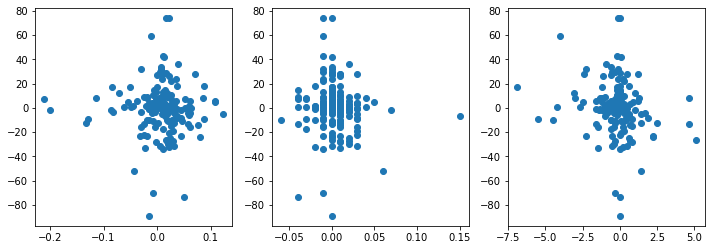

In [345]:
fig = plt.figure(figsize=(12, 4)) 
ax = fig.add_subplot(1, 3, 1)
plt.plot(the_less200['students_growth'], the_less200['rank_growth'], 'o')
ax = fig.add_subplot(1, 3, 2)
plt.plot(the_less200['int_stud_growth'], the_less200['rank_growth'], 'o')
ax = fig.add_subplot(1, 3, 3)
plt.plot(the_less200['staff_rate_growth'], the_less200['rank_growth'], 'o')
plt.show()

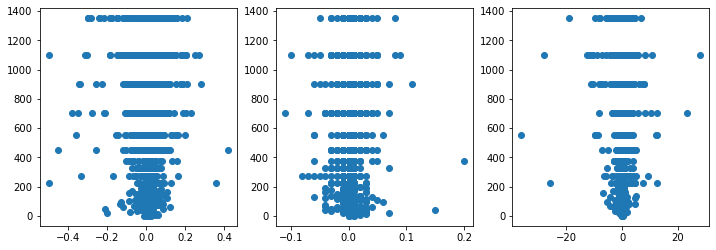

In [346]:
fig = plt.figure(figsize=(12, 4)) 
ax = fig.add_subplot(1, 3, 1)
plt.plot(the_compare['students_growth'], the_compare['rank_2023'], 'o')
ax = fig.add_subplot(1, 3, 2)
plt.plot(the_compare['int_stud_growth'], the_compare['rank_2023'], 'o')
ax = fig.add_subplot(1, 3, 3)
plt.plot(the_compare['staff_rate_growth'], the_compare['rank_2023'], 'o')
plt.show()

由上述的分析結果可以知道
- QS的資料較能解釋排名的變異  

在觀察QS的資料時我們發現  
- 學生人數, 師生比, 國際學生人數, Research Output, Size 對排名影響較大

近年來, 兩個機構間學生人數對排名的影響的差異以減少, 不論是THE還是QS的資料皆顯示學生人數越多平均下來排名也會越後,因此為了不同排名機構而報不同學生人數的現象也會因此減少

### 合併QS, THE  
找出差異人數的離群值

In [372]:
merge_table = pd.merge(the, qs, how = 'outer', on = 'University')

In [373]:
print('QS的學校,但和THE對不起來共有', len(merge_table[merge_table['rank_2023_x'].isna()]['University']), '所')

QS的學校,但和THE對不起來共有 580 所


In [374]:
print('THE的學校,但和THE對不起來共有', len(merge_table[merge_table['rank_2023_y'].isna()]['University']), '所')

THE的學校,但和THE對不起來共有 620 所


合併資料，觀察可以對上的資料

In [375]:
merge_inner = pd.merge(the, qs, how = 'inner', on = 'University')

In [376]:
merge_inner = merge_inner.drop(['Status', 'Research Output', 'Size','Int\'l staff rate_2023', 'Domestic staff rate_2023', 'Int\'l staff rate_2022', 'Domestic staff rate_2022'], axis = 1)

In [377]:
merge_inner = merge_inner.rename(columns={'rank_2023_x':'rank_2023_the', 'Total Students_2023':'Total students_2023_the',
'student staff ratio_2023': 'student staff ratio_2023_the', 'pc of int\'l students_2023':'pc of int\'l students_2023_the',
'rank_2022_x': 'rank_2022_the', 'Total Students_2022':'Total students_2022_the',
'student staff ratio_2022': 'student staff ratio_2022_the', 'pc of int\'l students_2022':'pc of int\'l students_2022_the', 
'Total students_2023':'Total students_2023_qs', 'International students_2023':'International students_2023_qs',
'Total faculty staff_2023':'Total faculty staff_2023_qs', 'rank_2023_y':'rank_2023_qs',
'Total students_2022':'Total students_2022_qs', 'International students_2022':'International students_2022_qs',
'Total faculty staff_2022':'Total faculty staff_2022_qs', 'rank_2022_y':'rank_2022_qs'})

In [379]:
merge_inner.head()

,rank_2023_the,University,Total students_2023_the,student staff ratio_2023_the,pc of int'l students_2023_the,rank_2022_the,Total students_2022_the,student staff ratio_2022_the,pc of int'l students_2022_the,Total students_2023_qs,International students_2023_qs,Total faculty staff_2023_qs,rank_2023_qs,Total students_2022_qs,International students_2022_qs,Total faculty staff_2022_qs,rank_2022_qs
0,1,University of Oxford,20967,10.6,0.42,1,20835,10.7,0.42,21972,9024,6650,4,20889,8442,6708,2
1,2,Harvard University,21887,9.6,0.25,2,21574,9.5,0.24,21877,5379,4480,5,23663,5877,4646,5
2,3,University of Cambridge,20185,11.3,0.39,5,19681,11.1,0.39,20871,7865,5735,2,20383,7925,5800,3
3,3,Stanford University,16164,7.1,0.24,4,16319,7.3,0.23,14518,3318,4694,3,16164,3879,4725,3
4,5,Massachusetts Institute of Technology,11415,8.2,0.33,5,11459,8.4,0.33,11035,3627,2919,1,11333,3730,3065,1


- 比較學生人數, 排名和人數差異的關係

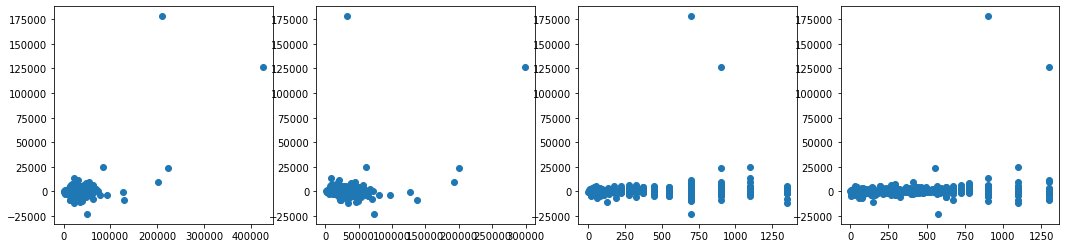

In [381]:
fig = plt.figure(figsize=(18, 4)) 
ax = fig.add_subplot(1, 4, 1)
plt.plot(merge_inner['Total students_2023_the'], merge_inner['Total students_2023_the'] - merge_inner['Total students_2023_qs'], 'o')
ax = fig.add_subplot(1, 4, 2)
plt.plot(merge_inner['Total students_2023_qs'], merge_inner['Total students_2023_the'] - merge_inner['Total students_2023_qs'], 'o')
ax = fig.add_subplot(1, 4, 3)
plt.plot(merge_inner['rank_2023_the'], merge_inner['Total students_2023_the'] - merge_inner['Total students_2023_qs'], 'o')
ax = fig.add_subplot(1, 4, 4)
plt.plot(merge_inner['rank_2023_qs'], merge_inner['Total students_2023_the'] - merge_inner['Total students_2023_qs'], 'o')
plt.show()

In [382]:
diff2023 = merge_inner[abs(merge_inner['Total students_2023_the'] - merge_inner['Total students_2023_qs']) > 100000]
print('共有', diff2023.shape[0], '間大學2023年兩個機構的人數差距>100000')
print(list(diff2023['University']))

共有 2 間大學2023年兩個機構的人數差距>100000
['University of Dhaka', 'Al-Azhar University']


In [383]:
the_more_than_qs_2023 = merge_inner[merge_inner['Total students_2023_the'] - merge_inner['Total students_2023_qs'] > 100000]
print('共有', the_more_than_qs_2023.shape[0], '間大學2023年THE-QS人數>100000')
print(list(the_more_than_qs_2023['University']))

共有 2 間大學2023年THE-QS人數>100000
['University of Dhaka', 'Al-Azhar University']


In [384]:
qs_more_than_the_2023 = merge_inner[merge_inner['Total students_2023_the'] - merge_inner['Total students_2023_qs'] < -100000]
print('共有', qs_more_than_the_2023.shape[0], '間大學2023年QS-THE人數>100000')
print(list(qs_more_than_the_2023['University']))

共有 0 間大學2023年QS-THE人數>100000
[]


In [385]:
diff2022 = merge_inner[abs(merge_inner['Total students_2022_the'] - merge_inner['Total students_2022_qs']) > 100000]
print('共有', diff2022.shape[0], '間大學2022年兩個機構的人數差距>100000')
print(list(diff2022['University']))

共有 1 間大學2022年兩個機構的人數差距>100000
['University of Dhaka']


In [386]:
the_more_than_qs_2022 = merge_inner[merge_inner['Total students_2022_the'] - merge_inner['Total students_2022_qs'] > 100000]
print('共有', the_more_than_qs_2022.shape[0], '間大學2022年THE-QS人數>100000')
print(list(the_more_than_qs_2022['University']))

共有 1 間大學2022年THE-QS人數>100000
['University of Dhaka']


In [387]:
qs_more_than_the_2022 = merge_inner[merge_inner['Total students_2022_the'] - merge_inner['Total students_2022_qs'] < -100000]
print('共有', qs_more_than_the_2022.shape[0], '間大學2022年QS-THE人數>100000')
print(list(qs_more_than_the_2022['University']))

共有 0 間大學2022年QS-THE人數>100000
[]


University of Dhaka, Al-Azhar University這兩間大學是非常明顯的離群值，兩間學校的THE學生皆大於QS學生人數，且都是排名後面的學校。